In [1]:
%pwd


'/home/louis/dev/git/mlcourse.ai/other/other'

In [2]:
import sys, os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB : 
    # vs s exécuter sur google colab






    from google.colab import drive
    drive.mount('/content/gdrive')
    root_dir = "/content/gdrive/My Drive/cours_deep/cours_epsi/git/mlcourse.ai"
    get_file = lambda fn : os.path.join(root_dir, "data", fn)
else :
    # avec jupyter, le cad est le folder ou se trouve le notebook
    get_file = lambda fn : os.path.join("..", "..", "data", fn)
%pwd

'/home/louis/dev/git/mlcourse.ai/other/other'

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
orig_data = pd.read_csv(get_file("concrete_data.csv"))
orig_data.head()
import numpy as np

In [4]:
data = orig_data.copy()
data.shape

(1030, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
blast_furnace_slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
fly_ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarse_aggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fine_aggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
concrete_compressive_strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


No missing values, all numeric

In [7]:
#Changing column headers to just keep component names
data.columns = [col[:col.find("(")].strip() for col in data.columns]
data.head()

,cemen,blast_furnace_sla,fly_as,wate,superplasticize,coarse_aggregat,fine_aggregate,ag,concrete_compressive_strengt
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]],
                                                    data[[data.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1)

Rather than splitting training data further to validation set, we will perform cross validation in all our training models.

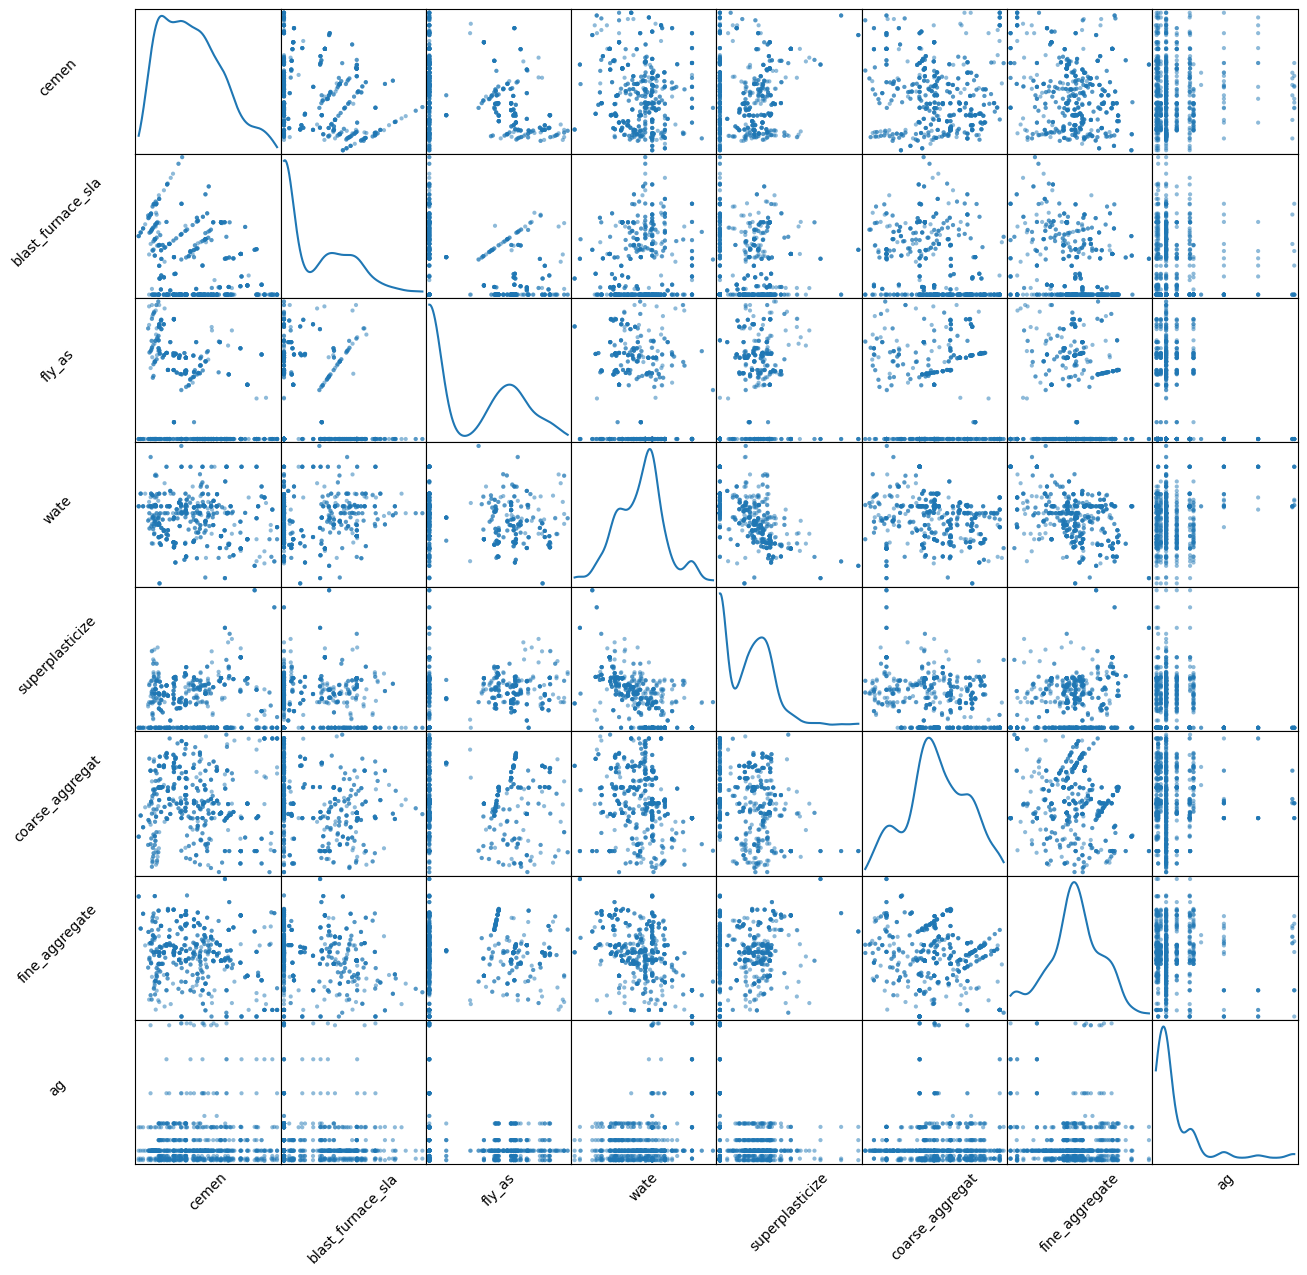

In [9]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
sm = scatter_matrix(x_train, figsize=(15,15), diagonal = 'kde')
#Changing label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]
#Changing offset for label
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
#Hiding ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

No high correlation between any two features. Lets verify with Heatmap.

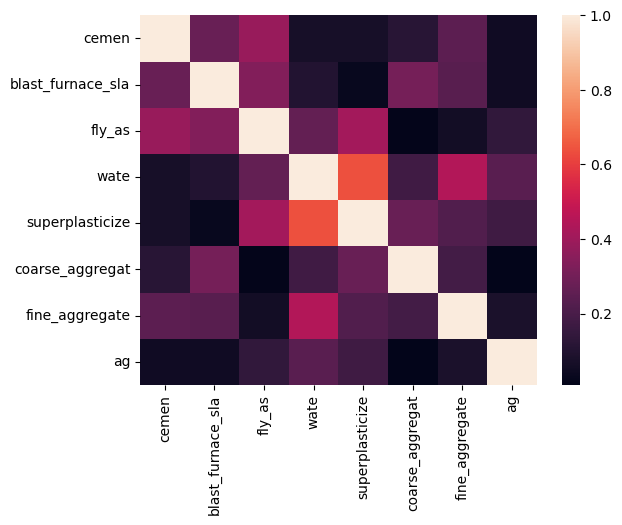

In [10]:
import seaborn as sns
sns.heatmap(x_train.corr().abs())
plt.show()

Little correlation of ~0.6 between Superplasticizer and Water (which is negative as evident from scatter matrix), but lets move forward as is.

In [11]:
#Scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train),
                              columns = x_train.columns)
x_train_scaled.head()

,cemen,blast_furnace_sla,fly_as,wate,superplasticize,coarse_aggregat,fine_aggregate,ag
0,-0.024603,-0.836937,-0.849294,0.452814,-1.038637,-0.071980,1.010322,-0.274315
1,0.760688,-0.614365,1.345841,-1.313913,0.844374,-0.408323,0.307869,-0.687211
2,-0.064825,1.293898,-0.849294,0.199742,-1.038637,0.502390,-0.799453,-0.274315
3,0.827725,1.353641,-0.849294,0.452814,0.170636,-1.934801,-0.254094,-0.274315
4,-0.641344,-0.836937,0.713767,-1.056067,0.757997,0.391138,1.620818,-0.687211


In [12]:
#We will save the model performance metrics in a DataFrame
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
Model = []
RMSE = []
R_sq = []
cv = KFold(5)

#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)



from sklearn.svm import SVR



names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor', 'SVR']
models = [LinearRegression(), Ridge(), Lasso(),
          
          KNeighborsRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(), SVR(C=100)]

#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, x_train_scaled, y_train)

In [14]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,RMSE,R Squared
0,Linear Regression,10.278166,0.625282
1,Ridge Regression,10.276215,0.625366
2,Lasso Regression,10.871002,0.580476
3,K Neighbors Regressor,9.160723,0.700741
4,Decision Tree Regressor,7.918406,0.798282
5,Random Forest Regressor,5.329275,0.897870
6,Gradient Boosting Regressor,5.181778,0.903810
7,Adaboost Regressor,7.723186,0.788165
8,SVR,5.935243,0.874188


Gradient Boosting Regressor has the lowest RMSE, highest R-Squared

In [15]:
#tuning this base model
GradientBoostingRegressor()

GradientBoostingRegressor()

In [16]:
#tuning for number of trees
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(20,1001,150),
              'max_depth':[10], #range(5,16,2), 
              'min_samples_split':[100], #range(200,1001,200), 
              'learning_rate':[0.2]}
clf = GridSearchCV(GradientBoostingRegressor(random_state=1), 
                   param_grid = param_grid, scoring='r2', 
                   cv=cv).fit(x_train_scaled, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)

GradientBoostingRegressor(learning_rate=0.2, max_depth=10,
                          min_samples_split=100, n_estimators=320,
                          random_state=1)
R Squared: 0.9312300753263909


In [17]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(20,1001,150),
              'max_depth':[10], #range(5,16,2), 
              'min_samples_split':[100], #range(200,1001,200), 
              'learning_rate':[0.2]}
clf = GridSearchCV(GradientBoostingRegressor(random_state=1), 
                   param_grid = param_grid, scoring='r2', 
                   cv=cv).fit(x_train_scaled, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)

GradientBoostingRegressor(learning_rate=0.2, max_depth=10,
                          min_samples_split=100, n_estimators=320,
                          random_state=1)
R Squared: 0.9312300753263909


In [18]:
#tuning the tree specific parameters
param_grid = {'C': np.arange(100, 200, 5),
             'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']  }
clf = GridSearchCV(SVR(), 
                   param_grid = param_grid, scoring='r2', 
                   cv=cv).fit(x_train_scaled, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)

SVR(C=160)
R Squared: 0.8767397575700487


In [19]:
#now increasing number of trees and decreasing learning rate proportionally
clf = GradientBoostingRegressor(random_state=1, max_depth=20, 
                                min_samples_split=170, n_estimators=230*2, 
                                learning_rate=0.2/2)
print("R Squared:",cross_val_score(clf, x_train_scaled, y_train, cv=cv, scoring='r2').mean())

R Squared: 0.9378095400092418


**Since score improved, the best model is GradientBoostingRegressor with learning_rate= 0.2/2, max_depth= 20, min_samples_split= 170, n_estimators= 230*2**

In [20]:
#applying this model on test data
x_test_scaled = pd.DataFrame(scaler.transform(x_test),
                             columns = x_test.columns)
clf = GradientBoostingRegressor(learning_rate=0.2/2, max_depth=20,
                                min_samples_split=170, n_estimators=230*2, 
                                random_state=1).fit(x_train_scaled, y_train)
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, clf.predict(x_test_scaled))))
print("Test R^2: ", r2_score(y_test, clf.predict(x_test_scaled)))

Test RMSE:  4.494302914170452
Test R^2:  0.9225194528332258
